## CNN Using PyTorch

In [1]:
!nvidia-smi

Mon Aug  2 13:21:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

data_folder='/content/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

fminst=datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images=fminst.data
tr_targets=fminst.targets

val_fminst=datasets.FashionMNIST(data_folder, download=True, train=False)
val_images=val_fminst.data
val_targets=val_fminst.targets

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(tr_images.shape)
print(val_images.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [4]:
from imgaug import augmenters as iaa
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10,10)}, mode='constant'),
    #iaa.Affine(rotate=30, fit_output=False, mode='constant'),
    #iaa.Affine(scale=2, fit_output=False, mode='constant'),
])

In [5]:
class FMINST(Dataset):
    def __init__(self, x, y, aug=None):
        self.x=x
        self.y=y
        self.aug=aug
    def __getitem__(self, ix):
        x=self.x[ix]
        y=self.y[ix]
        return x, y
    def __len__(self):
        return len(self.x)
    def collate_fn(self, batch):
        ims, classes=list(zip(*batch))
        ims=self.aug.augment_images(images=ims)
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [6]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [7]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [8]:
@torch.no_grad()
def vall_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [9]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [10]:
def get_data():
    train=FMINST(tr_images, tr_targets, aug)
    train_dl=DataLoader(train, batch_size=64, collate_fn=train.collate_fn, shuffle=True)
    val=FMINST(val_images, val_targets, aug)
    val_dl=DataLoader(val, batch_size=64, collate_fn=val.collate_fn, shuffle=True)
    return train_dl, val_dl

In [11]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Training the Model 

In [12]:
train_loss, train_accuracy=[], [] #For training
val_loss, val_accuracy=[], [] #For evaluation
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
for epoch in range(20):
    print(epoch)
    batch_losses_in_epoch, batch_accuracy_epoch=[], []  #For training
    val_batch_losses_in_epoch, val_batch_accuracy_epoch=[], []  #For evaluation
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        batch_losses_in_epoch.append(batch_loss)
        batch_accuracy_epoch.extend(is_correct)
    mean_batch_loss=np.mean(batch_losses_in_epoch)
    epoch_accuracy=np.mean(batch_accuracy_epoch)
    train_loss.append(mean_batch_loss)
    train_accuracy.append(epoch_accuracy)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_batch_loss = vall_loss(x, y, model, loss_fn)
        is_correct = accuracy(x, y, model)
        val_batch_losses_in_epoch.append(val_batch_loss)
        val_batch_accuracy_epoch.extend(is_correct)
    mean_batch_loss=np.mean(val_batch_losses_in_epoch)
    epoch_accuracy=np.mean(val_batch_accuracy_epoch)
    val_loss.append(mean_batch_loss)
    val_accuracy.append(epoch_accuracy)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


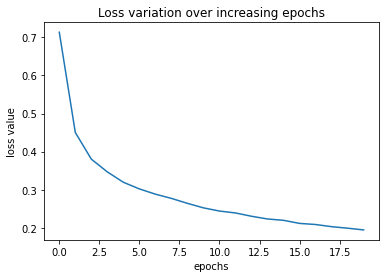

In [13]:
plt.plot(train_loss)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

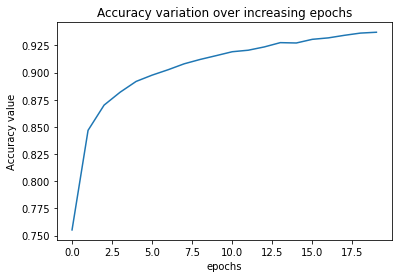

In [14]:
plt.plot(train_accuracy)
plt.title('Accuracy variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('Accuracy value')
plt.show()

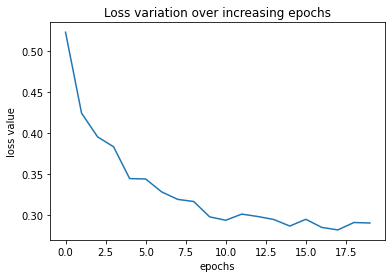

In [15]:
plt.plot(val_loss)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

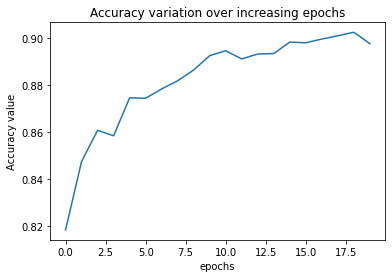

In [16]:
plt.plot(val_accuracy)
plt.title('Accuracy variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('Accuracy value')
plt.show()

## Predictions

Coat
[[ -5.8342814 -10.615602    1.8154509  -5.6001506   8.961556  -16.054905
    3.9907289 -16.456308  -17.878035  -13.399138 ]]


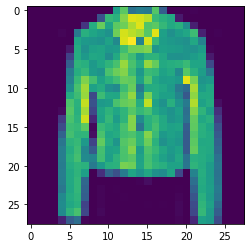

In [17]:
img=val_images[10]/255
img=img.view(28, 28)
#img2=np.roll(img, 5, axis=1)
img2=torch.Tensor(img).view(-1,1,28,28).to(device)
np_output=model(img2).cpu().detach().numpy()
pred = np.exp(np_output)/np.sum(np.exp(np_output))
print(fminst.classes[pred[0].argmax()])
print(np_output)
plt.imshow(img)

In [18]:
print(val_targets[10])

tensor(4)


Ankle boot
[[-10.311798   -4.5298953  -7.8935857  -5.0179625  -3.7948637  -3.6218598
  -11.462159   -0.7188607  -8.662796    8.767785 ]]


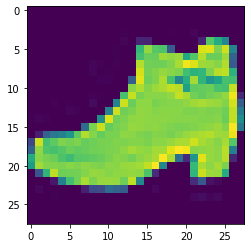

In [19]:
img=tr_images[24301]/255
img=img.view(28, 28)
#img2=np.roll(img, 5, axis=1)
img2=torch.Tensor(img).view(-1,1,28,28).to(device)
np_output=model(img2).cpu().detach().numpy()
pred = np.exp(np_output)/np.sum(np.exp(np_output))
print(fminst.classes[pred[0].argmax()])
print(np_output)
plt.imshow(img)

In [20]:
print(tr_targets[24301])

tensor(9)
